In [2]:
import chess
import chess.svg
import chess.pgn
from IPython.display import display, SVG, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import math
from tqdm import trange, tqdm
import os
import tarfile

ModuleNotFoundError: No module named 'chess'

## Check if cuda is available

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Display board

In [3]:
def display_board(board, size=400):
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board, size=size)))

In [4]:
def encode(board):
    channels = 18
    input_tensor = np.zeros((channels, 8, 8), dtype=np.float32)
    piece_to_token = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5, 'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}
    for rank in range(8):
        for file in range(8):
            index = chess.square(file, rank)
            piece = board.piece_at(index)
            if piece:
                token = piece_to_token[piece.symbol()]
                input_tensor[token, rank, file] = 1
    input_tensor[12, :, :] = int(board.turn)
    castling_rights = board.castling_rights
    if castling_rights & chess.BB_H1:
        input_tensor[13, 0, 0] = 1
    if castling_rights & chess.BB_A1:
        input_tensor[13, 0, 7] = 1
    if castling_rights & chess.BB_H8:
        input_tensor[13, 7, 0] = 1
    if castling_rights & chess.BB_A8:
        input_tensor[13, 7, 7] = 1
    ep_square = board.ep_square
    if ep_square:
        ep_file, ep_rank = chess.square_file(ep_square), chess.square_rank(ep_square)
        input_tensor[14, ep_rank, ep_file] = 1
    return input_tensor

## AlphaZero Model

In [5]:
class InputBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(16, 256, kernel_size=3, padding="same")  # batch_size x 18 x 8 x 8
        self.bn = nn.BatchNorm2d(256)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        return x

class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(256)

    def forward(self, x):
        res = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += res
        out = F.relu(out)
        return out

class ValueHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.to(device)
        self.conv = nn.Conv2d(256, 4, kernel_size=1, padding="same")
        self.bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(4 * 8 * 8, 4 * 8 * 8)
        self.fc2 = nn.Linear(4 * 8 * 8, 1)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

class PolicyHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(256, 2, kernel_size=1, padding="same")
        self.bn = nn.BatchNorm2d(2)
        self.fc = nn.Linear(2 * 8 * 8, 4608)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = nn.Flatten()(x)
        x = self.fc(x)
        return x

class AlphaZeroChessModel(nn.Module):
    def __init__(self, res_block_num=20):
        super().__init__()
        self.input_block = InputBlock()
        self.res_blocks = nn.ModuleList([ResBlock() for _ in range(res_block_num)])
        self.value_head = ValueHead()
        self.policy_head = PolicyHead()
        self.softmax = nn.Softmax(dim=1)
        self.loss_mse = nn.MSELoss()
        self.loss_entropy = nn.CrossEntropyLoss()

    def forward(self, x, value_target=None, policy_target=None, policy_mask=None):
        x = self.input_block(x)
        for res_block in self.res_blocks:
            x = res_block(x)
        value = self.value_head(x)
        policy = self.policy_head(x)
        if self.training:
            value_loss = self.loss_mse(value, value_target)
            policy_loss = self.loss_entropy(policy, torch.squeeze(policy_target))
            return value_loss, policy_loss
        else:
            masked_logits = policy * policy_mask.view(policy_mask.shape[0], 4608)
            policy_softmax = nn.Softmax(dim=1)(masked_logits)
            return value, policy_softmax

## Board Encoding

In [6]:
def parse_result(result):
    if result == "1-0":
        return 1
    elif result == "1/2-1/2":
        return 0
    elif result == "0-1":
        return -1
    else:
        raise Exception(f"Unexpected result string {result}")


def encode_position(board: chess.Board):
    planes = np.zeros((16, 8, 8), dtype=np.float32)

    white_pawns = board.pieces(chess.PAWN, chess.WHITE)
    white_pawns = [(chess.square_rank(i), chess.square_file(i)) for i in white_pawns]
    for rank, file in white_pawns:
        planes[0, rank, file] = 1.

    black_pawns = board.pieces(chess.PAWN, chess.BLACK)
    black_pawns = [(chess.square_rank(i), chess.square_file(i)) for i in black_pawns]
    for rank, file in black_pawns:
        planes[1, rank, file] = 1.

    white_rooks = board.pieces(chess.ROOK, chess.WHITE)
    white_rooks = [(chess.square_rank(i), chess.square_file(i)) for i in white_rooks]
    for rank, file in white_rooks:
        planes[2, rank, file] = 1.

    black_rooks = board.pieces(chess.ROOK, chess.BLACK)
    black_rooks = [(chess.square_rank(i), chess.square_file(i)) for i in black_rooks]
    for rank, file in black_rooks:
        planes[3, rank, file] = 1.

    white_bishops = board.pieces(chess.BISHOP, chess.WHITE)
    white_bishops = [(chess.square_rank(i), chess.square_file(i)) for i in white_bishops]
    for rank, file in white_bishops:
        planes[4, rank, file] = 1.

    black_bishops = board.pieces(chess.BISHOP, chess.BLACK)
    black_bishops = [(chess.square_rank(i), chess.square_file(i)) for i in black_bishops]
    for rank, file in black_bishops:
        planes[5, rank, file] = 1.

    white_knights = board.pieces(chess.KNIGHT, chess.WHITE)
    white_knights = [(chess.square_rank(i), chess.square_file(i)) for i in white_knights]
    for rank, file in white_knights:
        planes[6, rank, file] = 1.

    black_knights = board.pieces(chess.KNIGHT, chess.BLACK)
    black_knights = [(chess.square_rank(i), chess.square_file(i)) for i in black_knights]
    for rank, file in black_knights:
        planes[7, rank, file] = 1.

    white_queens = board.pieces(chess.QUEEN, chess.WHITE)
    white_queens = [(chess.square_rank(i), chess.square_file(i)) for i in white_queens]
    for rank, file in white_queens:
        planes[8, rank, file] = 1.

    black_queens = board.pieces(chess.QUEEN, chess.BLACK)
    black_queens = [(chess.square_rank(i), chess.square_file(i)) for i in black_queens]
    for rank, file in black_queens:
        planes[9, rank, file] = 1.

    white_kings = board.pieces(chess.KING, chess.WHITE)
    white_kings = [(chess.square_rank(i), chess.square_file(i)) for i in white_kings]
    for rank, file in white_kings:
        planes[10, rank, file] = 1.

    black_kings = board.pieces(chess.KING, chess.BLACK)
    black_kings = [(chess.square_rank(i), chess.square_file(i)) for i in black_kings]
    for rank, file in black_kings:
        planes[11, rank, file] = 1.

    if board.has_queenside_castling_rights(chess.WHITE):
        planes[12, :, :] = 1.

    if board.has_kingside_castling_rights(chess.WHITE):
        planes[13, :, :] = 1.

    if board.has_queenside_castling_rights(chess.BLACK):
        planes[14, :, :] = 1.

    if board.has_kingside_castling_rights(chess.BLACK):
        planes[15, :, :] = 1.

    return planes


def move_to_index(move):
    # 4 directions for rook x 8 distances = 32
    # 4 directions for bishop x 8 distances = 32
    # 8 directions for knight x 1 distance = 8
    # Maps a legal move to an index in (72, 8, 8)

    from_rank = chess.square_rank(move.from_square)
    from_file = chess.square_file(move.from_square)

    to_rank = chess.square_rank(move.to_square)
    to_file = chess.square_file(move.to_square)

    if from_rank == to_rank and from_file < to_file:
        direction = 0
        distance = to_file - from_file
        res = direction + distance
    elif from_rank == to_rank and from_file > to_file:
        direction = 8
        distance = from_file - to_file
        res = direction + distance
    elif from_file == to_file and from_rank < to_rank:
        direction = 16
        distance = to_rank - from_rank
        res = direction + distance
    elif from_file == to_file and from_rank > to_rank:
        direction = 24
        distance = from_rank - to_rank
        res = direction + distance
    elif to_file - from_file == to_rank - from_rank and to_file - from_file > 0:
        direction = 32
        distance = to_rank - from_rank
        res = direction + distance
    elif to_file - from_file == to_rank - from_rank and to_file - from_file < 0:
        direction = 40
        distance = from_rank - to_rank
        res = direction + distance
    elif to_file - from_file == -(to_rank - from_rank) and to_file - from_file > 0:
        direction = 48
        distance = to_file - from_file
        res = direction + distance
    elif to_file - from_file == -(to_rank - from_rank) and to_file - from_file < 0:
        direction = 56
        distance = from_file - to_file
        res = direction + distance
    elif to_file - from_file == 1 and to_rank - from_rank == 2:
        res = 64
    elif to_file - from_file == 2 and to_rank - from_rank == 1:
        res = 65
    elif to_file - from_file == 2 and to_rank - from_rank == -1:
        res = 66
    elif to_file - from_file == 1 and to_rank - from_rank == -2:
        res = 67
    elif to_file - from_file == -1 and to_rank - from_rank == 2:
        res = 68
    elif to_file - from_file == -2 and to_rank - from_rank == 1:
        res = 69
    elif to_file - from_file == -2 and to_rank - from_rank == -1:
        res = 70
    elif to_file - from_file == -1 and to_rank - from_rank == -2:
        res = 71

    return res, from_rank, from_file


def get_legal_moves_mask(board):
    mask = np.zeros((72, 8, 8), dtype=np.int32)
    for i in board.legal_moves:
        mask[*move_to_index(i)] = 1
    return mask


def mirror_move(move):
    from_square = move.from_square
    to_square = move.to_square
    new_from_square = chess.square_mirror(from_square)
    new_to_square = chess.square_mirror(to_square)
    return chess.Move(new_from_square, new_to_square)


def encode_training_point(board, move, winner):
    if not board.turn:  # see everything from white's perspective
        board = board.mirror()
        winner *= -1
        move = mirror_move(move)
    position_planes = encode_position(board)
    plane_index, rank_index, file_index = move_to_index(move)
    move_index = plane_index * 64 + rank_index * 8 + file_index  # https://stackoverflow.com/questions/7367770/how-to-flatten-or-index-3d-array-in-1d-array
    mask = get_legal_moves_mask(board)
    return position_planes, move_index, float(winner), mask


def encode_position_and_mask(board):
    if not board.turn:
        board = board.mirror()
    return encode_position(board), get_legal_moves_mask(board)


def decode_policy_output(board, policy):
    move_probs = np.zeros(200, dtype=np.float32)  # 200 is more than enough to accomodate the max number of moves for a single position
    num_moves = 0
    for i, move in enumerate(board.legal_moves):
        if not board.turn:
            move = mirror_move(move)
        plane_index, rank_index, file_index = move_to_index(move)
        move_index = plane_index * 64 + rank_index * 8 + file_index
        move_probs[i] = policy[move_index]
        num_moves += 1
    return move_probs[:num_moves]


def call_model(board, model):
    position, mask = encode_position_and_mask(board)
    position = torch.from_numpy(position)[None, ...].to(device)
    mask = torch.from_numpy(mask)[None, ...].to(device)
    model.eval()
    with torch.no_grad():
        value, policy = model(position, policy_mask=mask)
    value = value.cpu().numpy()[0, 0]
    policy = policy.cpu().numpy()[0]
    move_probs = decode_policy_output(board, policy)
    return value, move_probs


def call_model_batched(boards, model):
    batch_size = len(boards)
    inputs = torch.zeros((batch_size, 16, 8, 8), dtype=torch.float32)
    masks = torch.zeros((batch_size, 72, 8, 8), dtype=torch.float32)
    for i in range(batch_size):
        position, mask = encode_position_and_mask(boards[i])
        inputs[i] = torch.from_numpy(position).to(device)
        masks[i] = torch.from_numpy(masks).to(device)
    value, policy = model(inputs, policy_mask=masks)
    move_probs = np.zeros((batch_size, 200), dtype=np.float32)
    value = value.cpu().numpy().reshape((batch_size))
    policy = policy.cpu().numpy()
    for i in range(batch_size):
        move_probs_tmp = decode_policy_output(boards[i], policy[i])
        move_probs[i, :move_probs_tmp.shape[0]] = move_probs_tmp
    return value, move_probs

## Monte Carlo Tree Search

In [7]:
def get_uct(edge, N_p):
    # https://int8.io/monte-carlo-tree-search-beginners-guide/
    Q = edge.getQ()
    N_c = edge.getN()
    P = edge.getP()
    C = 1.5
    return (1 - (Q / N_c)) + C * P * (math.sqrt(N_p) / (1 + N_c))


class Node:
    def __init__(self, board, Q, move_probs):
        self.N = 1
        self.sum_Q = Q
        self.edges = []
        for i, move in enumerate(board.legal_moves):
            edge = Edge(move, move_probs[i])
            self.edges.append(edge)

    def getN(self):
        return self.N

    def getQ(self):
        return self.sum_Q

    def select_max_uct(self):
        max_uct = float("-inf")
        max_edge = None
        for i in self.edges:
            uct = get_uct(i, self.N)
            if max_uct < uct:
                max_edge= i
        return max_edge

    def select_max_N(self):
        max_N = float("-inf")
        max_edge = None
        for i in self.edges:
            N = i.getN()
            if max_N < N:
                max_N = N
                max_edge = i
        return max_edge

    def get_statistics(self):
        res = f"|{'move': ^10}|{'P': ^10}|{'N': ^10}|{'Q': ^10}|{'UCT': ^10}|\n"
        edges = self.edges.copy()
        edges.sort(key=lambda x: x.getN(), reverse=True)
        for i in edges:
            move = i.get_move()
            P = i.getP()
            N = i.getN()
            Q = i.getQ()
            uct = get_uct(i, self.N)
            res += f"|{str(move): ^10}|{P: ^10}|{N: ^10}|{Q: ^10}|{uct: ^10}|\n"
        return res

    def is_terminal(self):
        return len(self.edges) == 0


class Edge:
    def __init__(self, move, prob):
        self.move = move
        self.P = prob
        self.child = None
        # Virtual losses are then added to an edge to discourage other threads from selecting the same edge in parallel processing
        self.virtual_loss = 0.

    def has_child(self):
        return self.child is not None

    def getN(self):
        if self.has_child():
            return self.child.getN() + self.virtual_loss
        return 1.

    def getQ(self):
        if self.has_child():
            return self.child.getQ() + self.virtual_loss
        else:
            return 0.

    def getP(self):
        return self.P

    def expand(self, board, Q, move_probs):
        if self.child is None:  # if node has not been expanded yet
            self.child = Node(board, Q, move_probs)
            return True
        return False

    def get_child(self):
        return self.child

    def get_move(self):
        return self.move

    def add_virtual_loss(self):
        self.virtual_loss += 1

    def clear_virtual_loss(self):
        self.virtual_loss = 0.


class Root(Node):
    def __init__(self, board, model):
        evaluation, move_probs = call_model(board, model)
        Q = evaluation / 2. + 0.5
        super().__init__(board, Q, move_probs)
        self.same_paths = 0

    def select(self, board, node_path, edge_path):
        node = self
        while True:
            node_path.append(node)
            edge = node.select_max_uct()
            edge_path.append(edge)
            if edge is None:
                break
            edge.add_virtual_loss()
            board.push(edge.get_move())
            if not edge.has_child():
                break
            node = edge.get_child()

    def rollout(self, board, model):
        node_path = []
        edge_path = []
        self.select(board, node_path, edge_path)
        edge = edge_path[-1]
        if edge is not None:
            value, move_probs = call_model(board, model)
            Q = value / 2. + 0.5
            edge.expand(board, Q, move_probs)
            Q = 1. - Q
        else:
            winner = parse_result(board.result())
            if not board.turn:
                winner *= -1
            Q = float(winner) / 2. + 0.5
        last_node_index = len(node_path) - 1
        for i in range(last_node_index, -1, -1):
            node = node_path[i]
            node.N += 1
            if (last_node_index - i) % 2 == 0:
                node.sum_Q += Q
            else:
                node.sum_Q += 1. - Q
        for edge in edge_path:
            if edge is not None:
                edge.clear_virtual_loss()

## Training

In [8]:
# tar.extract('data/new_pgns/.ipynb_checkpoints/game_1_1-checkpoint.pgn')
# with open(game_file.name, "r") as f:
#     game = chess.pgn.read_game(f)
#     moves = []
#     for i in game.mainline_moves():
#         moves.append(i)

In [9]:
# members = tar.getmembers()

In [10]:
# members[:101][:10]

In [11]:
# members100 = members[:101]
# new = []
# for i in members100:
#     if i.name.endswith(".pgn") and ("ipynb_checkpoints" not in i.name):
#         new.append(i)

In [12]:
# # testing tar
# # tar = tarfile.open("pgns.tar", "r")
# broken = []
# for game_file in tar.getmembers():
#     if game_file.name.endswith(".pgn"):
#         tar.extract(game_file)
#         with open(game_file.name, "r") as f:
#             game = chess.pgn.read_game(f)
#             moves = []
#             for i in game.mainline_moves():
#                 moves.append(i)
#             print(len(moves))
#             if len(moves) == 0:
#                 broken.append(game_file.name)

In [13]:
import chess.pgn

class GameData(Dataset):
    def __init__(self, pgn_dir="pgns.tar"):
        self.tar = tarfile.open(pgn_dir, "r")
        self.members = []
        for i in self.tar.getmembers():
            if i.name.endswith(".pgn") and ("ipynb_checkpoints" not in i.name):
                self.members.append(i)

    def __len__(self):
        return len(self.members)

    def __getitem__(self, idx):
        file_to_read = self.members[idx]
        self.tar.extract(file_to_read)
        with open(file_to_read.name, "r") as f:
            game = chess.pgn.read_game(f)
            moves = []
            for i in game.mainline_moves():
                moves.append(i)
            rand_idx = np.random.randint(0, len(moves) - 1, dtype=int)
            board = game.board()
            for i, move in enumerate(moves):
                board.push(move)
                if i == rand_idx:
                    next_move = moves[i + 1]
                    break
            winner = parse_result(game.headers["Result"])
            position, policy, value, mask = encode_training_point(board, next_move, winner)
            return {"position": torch.from_numpy(position),
                    "policy": torch.Tensor([policy]).type(torch.long),
                    "value": torch.Tensor([value]),
                    "mask": torch.from_numpy(mask)}


def train(epochs=10, load_model_path=None):
    print("Fetching data")
    data_path = os.path.join("pgns.tar")
    data = GameData(data_path)
    dataloader = DataLoader(data, batch_size=256, shuffle=True)

    model = AlphaZeroChessModel().to(device)
    optimizer = optim.Adam(model.parameters())
    if load_model_path is not None:
        model_data = torch.load(load_model_path, map_location=device)
        model.load_state_dict(model_data["model_state_dict"])
        optimizer.load_state_dict(model_data["optimizer_state_dict"])

    print("Starting training")
    for epoch in range(epochs):
        model.train()
        print(f"Epoch #{epoch + 1}")
        pbar = tqdm(dataloader)
        for i, data in enumerate(pbar):
            position = data["position"].to(device)
            value = data["value"].to(device)
            policy = data["policy"].to(device)

            value_loss, policy_loss = model(position, value_target=value, policy_target=policy)
            loss = value_loss + policy_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix({"loss": f"{loss.item():.3f}"})
            pbar.set_postfix({"loss": f"{loss.item():.3f}"})

        # if (epoch + 1) % 250 == 0:
        save_info = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }
        torch.save(save_info, f"models/model_epoch_{epoch + 1}.pth")

In [14]:
# # testing data loader
# data_path = os.path.join("pgns.tar")
# data = GameData(data_path)
# dataloader = DataLoader(data, batch_size=256, shuffle=True)
# next(iter(dataloader))["position"].shape

In [20]:
%pwd

'D:\\Programming\\DeepLearning\\Chess'

In [ ]:
train(epochs=100)

Fetching data
Starting training
Epoch #1


 43%|██████████████████████████▋                                   | 3358/7813 [1:26:56<2:34:45,  2.08s/it, loss=3.635]

## Gameplay

In [8]:
def check_end(board: chess.Board):
    outcome = board.outcome()
    if outcome is not None:
        if outcome.winner:  # if white has won
            print(f"Game has ended, white has won by ", end="")
        elif outcome.winner is None:
            print(f"Game has ended, it is a draw by ", end="")
        else:
            print(f"Game has ended, black has won by ", end="")
        if outcome.termination == chess.Termination.CHECKMATE:
            print("checkmate!")
        elif outcome.termination == chess.Termination.STALEMATE:
            print("stalemate!")
        elif outcome.termination == chess.Termination.INSUFFICIENT_MATERIAL:
            print("insufficient material!")
        elif outcome.termination == chess.Termination.FIFTY_MOVES:
            print("fifty moves!")
        else:
            print("repetition!")
        return True
    return False

In [9]:
def play_chess(model_path, player_color=True):
    num_rollouts = 30
    
    model = AlphaZeroChessModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)["model_state_dict"])
    
    board = chess.Board()
    
    while True:
        display_board(board)
        if check_end(board):
            break
        if board.turn == player_color:
            legal_moves = {}
            for i in board.legal_moves:
                legal_moves[i] = str(i)
            print("White's turn!")
            move = input("Pick a move: ")
            if move not in list(legal_moves.values()):
                print("That's not a valid move!")
                continue
            board.push(list(legal_moves.keys())[list(legal_moves.values()).index(move)])
        else:
            with torch.no_grad():
                root = Root(board, model)
                for i in range(num_rollouts):
                    root.rollout(board.copy(), model)
            Q = root.getQ()
            N = root.getN()
            print(root.get_statistics())
            edge = root.select_max_N()
            best_move = edge.get_move()
            board.push(best_move)

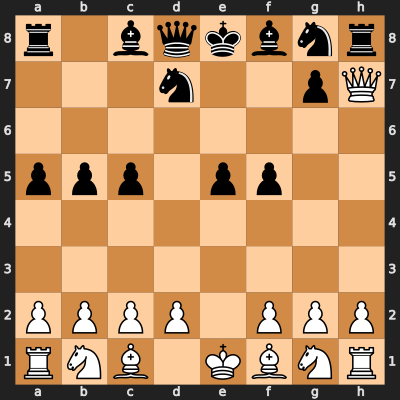

White's turn!


KeyboardInterrupt: Interrupted by user

In [10]:
play_chess("models/model_epoch_6.pth")